# Space-time tube planning - 1D case

In [29]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx, interpolate_positions,unit_cube

from panav.env import line_seg_to_obstacle

import shapely

from shapely.plotting import plot_polygon, plot_line

from polytope import qhull

import numpy as np
from matplotlib import pyplot as plt

import cvxpy as cp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def wp_to_tube_obstacle(t1,t2,p1,p2,bloating_r):
    '''
        Convert a timed line segment (t1,p1)-(t2,p2) to a space-time tube obstacle with bloating radius bloating_r. 
        Output: (Ap,bp) characterizing the polytopic space-time tube obstacle.
    '''
    p1,p2 = np.array(p1),np.array(p2)
    if len(p1.shape) == 0:
        d = 1
    else:
        d = p1.shape[0]
    
    tube_vertices = [np.hstack([t,p+1.0*bloating_r*unit_vec]) 
                     for t,p in zip([t1,t2],[p1,p2]) 
                     for unit_vec in unit_cube(d)]
    
    poly = qhull(np.vstack(tube_vertices))

    Ap,bp = poly.A,poly.b
    return Ap,bp


In [30]:
bloating_r = 0.5
vmax = 1.0

pb = np.array([[3.0, 4.0]])

d = pb.shape[0]

tb = np.array([1.0, 4.0])

pa0 = np.array([[1.0]])
ta0 = np.array([1.0])

tx = cp.Variable((d+1,2))

A,b = wp_to_tube_obstacle(*tb,pb[0,0],pb[0,1],bloating_r)

M = 100 * max([np.max(np.abs(A)),np.max(np.abs(b))])

H = A @ tx-(b+ np.linalg.norm(A,axis=1) * bloating_r).reshape(-1,1) # Bloating radius

alpha = cp.Variable((H.shape[0],1),boolean=True)

constraints = []

constraints.append(H + M * (1-alpha)>=0)

constraints.append(cp.sum(alpha,axis = 0)>=1)

constraints.append(tx[:,0] == np.vstack([ta0,pa0]).flatten())

prob = cp.Problem(cp.Minimize(cp.norm(tx[:,1]-np.array([3,5]))),constraints)
prob.solve(solver='GUROBI')


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


2.239252777514412

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/geometry/point.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords = np.asarray(coords).squeeze()


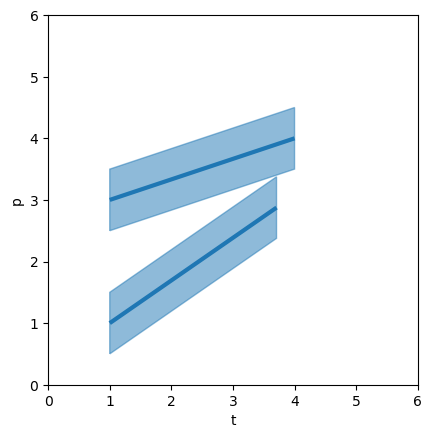

In [31]:

xlim = (0,6)
ylim = (0,6)

ax = plt.gca()


line = shapely.geometry.LineString(np.vstack([tb,pb]).T)
plot_line(line, ax=ax, add_points=False, linewidth=3)
tube_vertices = [(tb[i],pb[:,i]+bloating_r*unit_vec) 
                 for i in range(len(tb))
                  for unit_vec in unit_cube(d)]
plot_polygon(shapely.convex_hull(shapely.MultiPoint(tube_vertices)), ax=ax, add_points=False, alpha=0.5)



line = shapely.geometry.LineString(tx.value.T)
plot_line(line, ax=ax, add_points=False, linewidth=3)

ta = tx.value[0,:]
pa = tx.value[1:,:]

tube_vertices = [(ta[i],pa[:,i]+bloating_r*unit_vec) 
                 for i in range(len(ta))
                  for unit_vec in unit_cube(d)]
plot_polygon(shapely.convex_hull(shapely.MultiPoint(tube_vertices)), ax=ax, add_points=False, alpha=0.5)


ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_xlabel('t')
ax.set_ylabel('p')
ax.set_aspect('equal')
